In [41]:
from utils import *
import fastbook
fastbook.setup_book()
#hide
from fastbook import *
from fastai.tabular.all import *
import itertools
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import time
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)

In [2]:
path= Path('./space_ship_titanic')

In [3]:
path.ls()

(#6) [Path('space_ship_titanic/train.csv'),Path('space_ship_titanic/sample_submission.csv'),Path('space_ship_titanic/Untitled.ipynb'),Path('space_ship_titanic/submission.csv'),Path('space_ship_titanic/.ipynb_checkpoints'),Path('space_ship_titanic/test.csv')]

In [24]:
train = pd.read_csv(path/'train.csv')

In [64]:
test = pd.read_csv(path/'test.csv')

In [25]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [65]:
test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


*Cardinality*

In [26]:
train.nunique()

PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64

In [27]:
train.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

## Looking at the features

Text(0.5, 1.0, 'Target distribution')

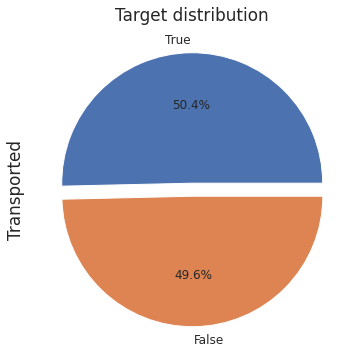

In [42]:
plt.figure(figsize=(6,6))
train['Transported'].value_counts().plot.pie(explode=[0.05, 0.05], textprops={'fontsize':12}, autopct='%1.1f%%').set_title("Target distribution")

Text(0.5, 0, 'Age (years)')

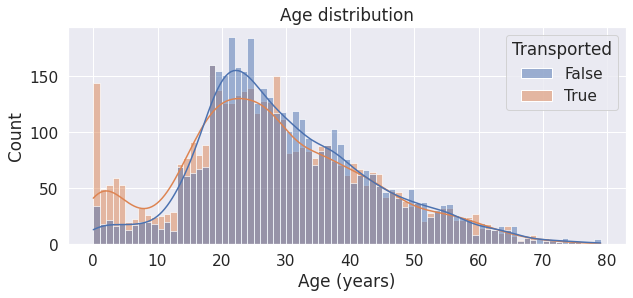

In [44]:
plt.figure(figsize=(10,4))
sns.histplot(data=train, x='Age', hue='Transported', binwidth=1, kde=True)
plt.title("Age distribution")
plt.xlabel("Age (years)")

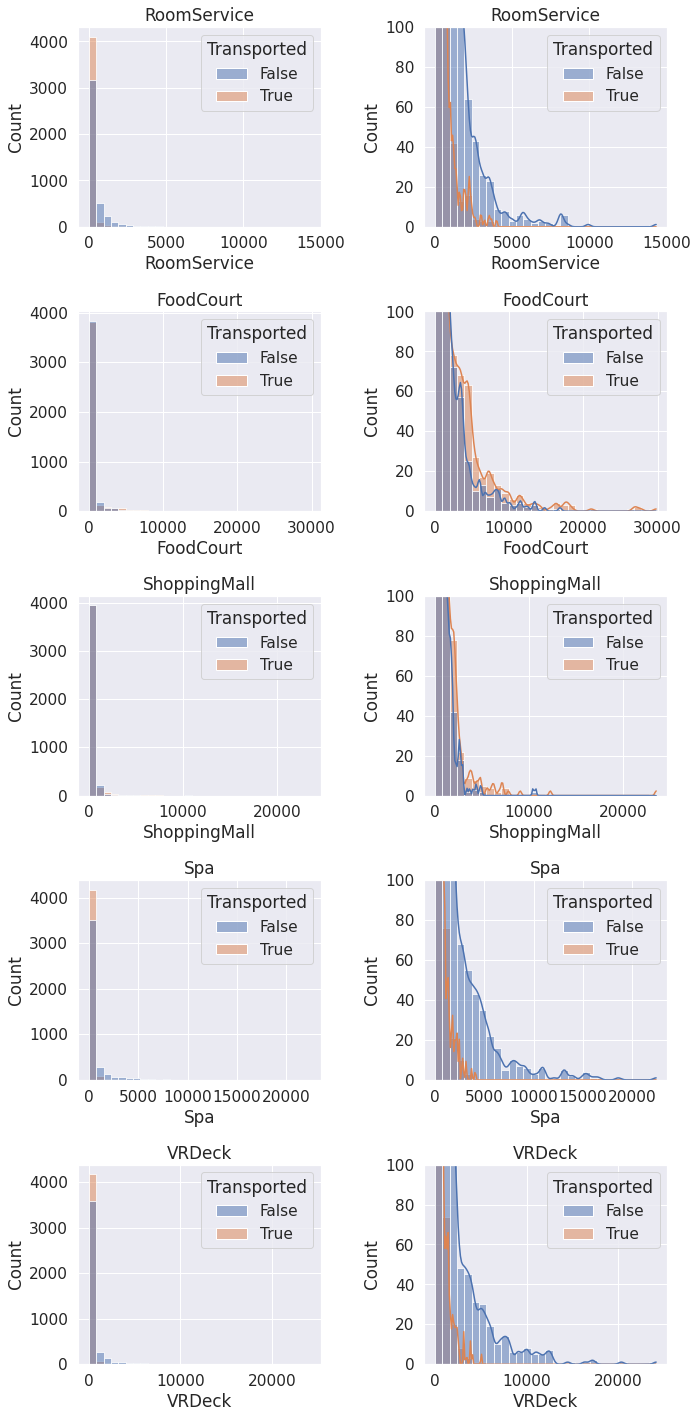

In [55]:
# Expenditure features
exp_feats=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
fig=plt.figure(figsize=(10,20))

for i,var_name in enumerate(exp_feats):
    ax=fig.add_subplot(5,2,2*i+1)
    sns.histplot(data=train,x=var_name, bins=30,ax=ax, kde=False,hue='Transported')
    ax.set_title(var_name)
    
    ax=fig.add_subplot(5,2,2*i+2)
    sns.histplot(data=train, x=var_name, bins=30,ax=ax, kde=True, hue='Transported')
    plt.ylim([0,100])
    ax.set_title(var_name)
    plt.ylim([0,100])
fig.tight_layout()  
plt.show()

## Categorical Features

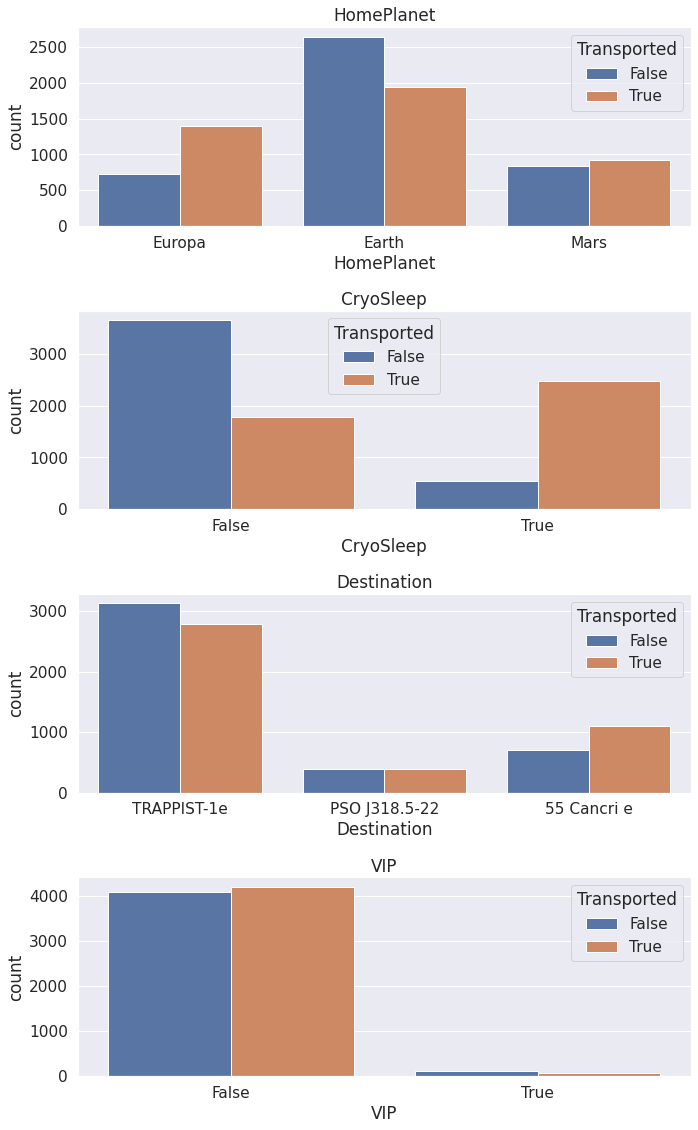

In [57]:
cat_feats=['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

fig=plt.figure(figsize=(10,16))
for i, var_name in enumerate(cat_feats):
    ax=fig.add_subplot(4,1,i+1)
    sns.countplot(data=train,x=var_name,ax=ax,hue='Transported')
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

In [66]:
# Age split
train["Age Group"] = pd.qcut(train['Age'], 5, duplicates="drop")
test["Age Group"] = pd.qcut(test['Age'], 5, duplicates="drop")

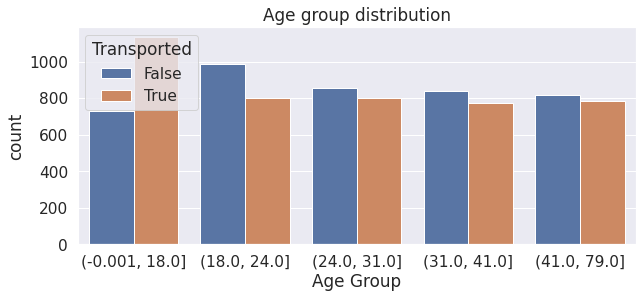

In [63]:
fig = plt.figure(figsize=(10,4))
sns.countplot(data=train, x="Age Group", hue="Transported")
plt.title('Age group distribution')
plt.show()

In [69]:
exp_feats=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

In [71]:
train['expenditure']=train[exp_feats].sum(axis=1)
train['spent_money']=(train['expenditure']>0).astype(int)
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Age Group,expenditure,spent_money
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,"(31.0, 41.0]",0.0,0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,"(18.0, 24.0]",736.0,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,"(41.0, 79.0]",10383.0,1
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,"(31.0, 41.0]",5176.0,1
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,"(-0.001, 18.0]",1091.0,1


In [72]:
test['expenditure']=test[exp_feats].sum(axis=1)
test['spent_money']=(test['expenditure']>0).astype(int)

In [76]:
train['Group'] = train['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)
test['Group'] = test['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)

train['Group_size']=train['Group'].map(
    lambda x: pd.concat([train['Group'], test['Group']]).value_counts()[x]
)
test['Group_size']=test['Group'].map(
    lambda x: pd.concat([train['Group'], test['Group']]).value_counts()[x]
)

train['solo']=(train['Group_size']==1).astype(int)
test['solo']=(test['Group_size']==1).astype(int)


In [78]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Age Group,expenditure,spent_money,Group,Group_size,solo
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,"(31.0, 41.0]",0.0,0,1,1,1
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,"(18.0, 24.0]",736.0,1,2,1,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,"(41.0, 79.0]",10383.0,1,3,2,0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,"(31.0, 41.0]",5176.0,1,3,2,0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,"(-0.001, 18.0]",1091.0,1,4,1,1


In [95]:
y=train['Transported'].copy().astype(int)
X=train.drop('Transported',axis=1).copy()

In [101]:
data=pd.concat([X, test], axis=0).reset_index(drop=True)

In [103]:
na_cols=data.columns[data.isna().any()].tolist()

['HomePlanet',
 'CryoSleep',
 'Cabin',
 'Destination',
 'Age',
 'VIP',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'Name',
 'Age Group']

In [110]:
GHP_gb=data.groupby(['Group', 'HomePlanet'])['HomePlanet'].size().unstack().fillna(0)

In [114]:
GHP_index=data[data['HomePlanet'].isna()][(data[data['HomePlanet'].isna()]['Group']).isin(GHP_gb.index)].index

In [115]:
data.loc[GHP_index,'HomePlanet']=data.iloc[GHP_index,:]['Group'].map(lambda x: GHP_gb.idxmax(axis=1)[x])